In [14]:
import matplotlib.pyplot as plt
import numpy as np
from pymongo import MongoClient
import copy
import math
from enum import Enum
import requests
import json
import pprint

class CollectibleType(Enum):
  All = 1
  Hands = 2
  Feet = 3
  Left = 4
  Right = 5
  LeftHand = 6
  RightHand = 7
  LeftFoot = 8
  RightFoot = 9

client = MongoClient('localhost', 27017)

db = client['beatfork']

versions = db.versions.find()

def calcDistanceXY(posA, posB):
  return ( (posA['x'] - posB['x']) ** 2 + (posA['y'] - posB['y']) ** 2 ) ** (1 / 2)

def calcDistanceZ(posA, posB):
  return abs(posA['z'] - posB['z'])

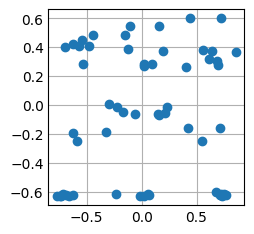

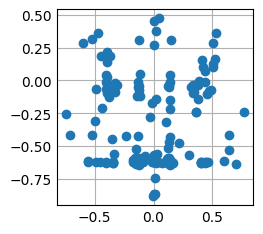

In [15]:
def plotXYOccurence(version):
  plt.style.use('_mpl-gallery')

  x = np.array(list(map(lambda obj:
    obj['position']['x']
  , version['objects'])))
  y = np.array(list(map(lambda obj:
    obj['position']['y']
  , version['objects'])))

  fig, ax = plt.subplots()

  ax.scatter(x, y, vmin=-1, vmax=1)

  plt.show()

for version in copy.deepcopy(versions):
  plotXYOccurence(version)

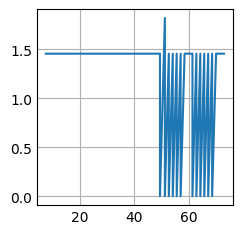

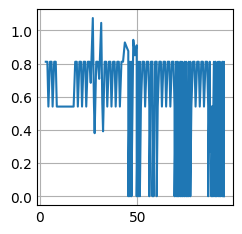

In [16]:
def plotZDistance(version):
  plt.style.use('_mpl-gallery')

  zDistanceBetweenBlocks = []
  lastZ = version['objects'].pop(0)['position']['z']
  for obj in version['objects']:
    zDistanceBetweenBlocks.append(obj['position']['z'] - lastZ)
    lastZ = obj['position']['z']

  x = np.array(list(map(lambda obj:
    obj['position']['z']
  , version['objects'])))
  y = np.array(zDistanceBetweenBlocks)

  fig, ax = plt.subplots()

  ax.plot(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotZDistance(version)

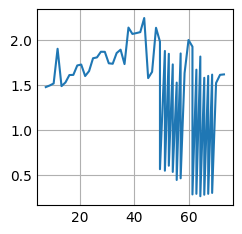

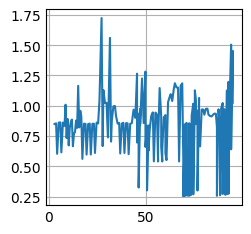

In [17]:
def plotDistance(version):
  plt.style.use('_mpl-gallery')

  distanceBetweenBlocks = []
  lastPosition = version['objects'].pop(0)['position']
  for obj in version['objects']:
    distanceBetweenBlocks.append((
      (obj['position']['x'] - lastPosition['x']) ** 2 +
      (obj['position']['y'] - lastPosition['y']) ** 2 +
      (obj['position']['z'] - lastPosition['z']) ** 2 ) ** 0.5)
    lastPosition = obj['position']

  x = np.array(list(map(lambda obj:
    obj['position']['z']
  , version['objects'])))
  y = np.array(distanceBetweenBlocks)

  fig, ax = plt.subplots()

  ax.plot(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotDistance(version)

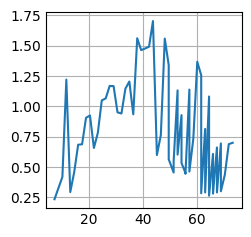

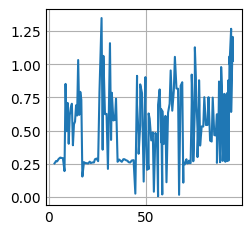

In [18]:
def plotXYDistance(version):
  plt.style.use('_mpl-gallery')

  distanceBetweenBlocks = []
  lastPosition = version['objects'].pop(0)['position']
  for obj in version['objects']:
    distanceBetweenBlocks.append((
      (obj['position']['x'] - lastPosition['x']) ** 2 +
      (obj['position']['y'] - lastPosition['y']) ** 2 ) ** 0.5)
    lastPosition = obj['position']

  x = np.array(list(map(lambda obj:
    obj['position']['z']
  , version['objects'])))
  y = np.array(distanceBetweenBlocks)

  fig, ax = plt.subplots()

  ax.plot(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotXYDistance(version)

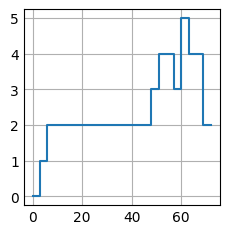

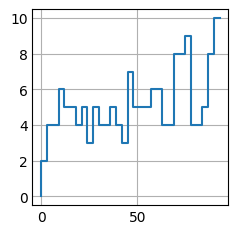

In [19]:
def plotDensity(version):
  secondsPerInterval = 3

  plt.style.use('_mpl-gallery')

  objects = version['objects']
  end = objects[-1]['position']['z']
  density = []
  for i in range(0, math.ceil(end / secondsPerInterval) * secondsPerInterval, secondsPerInterval):
    obstaclesInInterval = 0
    while len(objects) > 0 and objects[0]['position']['z'] < i:
      obstaclesInInterval += 1
      objects.pop(0)
    density.append(obstaclesInInterval)

  x = np.arange(0, math.ceil(end / secondsPerInterval) * secondsPerInterval, secondsPerInterval)
  y = np.array(density)

  fig, ax = plt.subplots()

  ax.step(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotDensity(version)

In [20]:
def pickMinSquareRootScore(options):
  minOption = options.pop()
  minScore = (
      (minOption['cumulatedIntensity'][6] ** 2) +
      (minOption['cumulatedIntensity'][7] ** 2) +
      (minOption['cumulatedIntensity'][8] ** 2) +
      (minOption['cumulatedIntensity'][9] ** 2)
    ) ** 0.5
  squareRoots = list(map(lambda option:
    (
      (option['cumulatedIntensity'][6] ** 2) +
      (option['cumulatedIntensity'][7] ** 2) +
      (option['cumulatedIntensity'][8] ** 2) +
      (option['cumulatedIntensity'][9] ** 2)
    ) ** 0.5
  , options))
  for i in range(0, len(options)):
    if squareRoots[i] < minScore:
      minScore = squareRoots[i]
      minOption = options[i]
  return minOption

def getMinIntensity(objects, cumulatedIntensity, lastPositions, calcIntensity):
  if len(objects) == 0:
    return {
      'cumulatedIntensity': cumulatedIntensity,
      'lastPositions': lastPositions,
    }
  obj = objects.pop(0)
  if obj[3] != 0:
    match obj[3]:
      case 1:
        obj[3] = 6
        a = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        obj[3] = 7
        b = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        obj[3] = 8
        c = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        obj[3] = 9
        d = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        return pickMinSquareRootScore([a, b, c, d])
      case 2:
        obj[3] = 6
        a = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        obj[3] = 7
        b = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        return pickMinSquareRootScore([a, b])
      case 3:
        obj[3] = 8
        a = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        obj[3] = 9
        b = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        return pickMinSquareRootScore([a, b])
      case 4:
        obj[3] = 6
        a = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        obj[3] = 8
        b = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        return pickMinSquareRootScore([a, b])
      case 5:
        obj[3] = 7
        a = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        obj[3] = 9
        b = getMinIntensity([obj, *objects], copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
        return pickMinSquareRootScore([a, b])
      case 6 | 7 | 8 | 9:
        intensity = calcIntensity(obj, lastPositions)
        cumulatedIntensity[obj[3]] += intensity
        lastPositions[obj[3]] = [obj[0], obj[1], obj[2]]
        return getMinIntensity(copy.deepcopy(objects), copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)
  else: # obstacle
    # todo
    return getMinIntensity(copy.deepcopy(objects), copy.deepcopy(cumulatedIntensity), copy.deepcopy(lastPositions), calcIntensity)

# %reload_ext line_profiler
# objects = [
#     [0.4041569099545159, 0.26385379945425225, 5.818181818181818, 1],
#     [0.19668416357129426, 0.37005910237923434, 7.272727272727273, 1],
#     [-0.1286331027576143, 0.38499422310305553, 8.727272727272727, 1],
#     [-0.5402590315819069, 0.44971307957296947, 10.181818181818182, 1],
#     [0.05560269603070369, -0.6139994075350503, 11.636363636363637, 1],
#     [-0.2365189308768725, -0.6123399496768461, 13.090909090909092, 1],
#     [-0.6929589729199602, -0.6222966968260651, 14.545454545454545, 1],
#     [-0.01078858281192716, -0.6272750704006718, 16, 1]
# ]
# cumulatedIntensity = {
#   CollectibleType.LeftHand.value: 0,
#   CollectibleType.RightHand.value: 0,
#   CollectibleType.LeftFoot.value: 0,
#   CollectibleType.RightFoot.value: 0
# }
# startPositions = {
#   CollectibleType.LeftHand.value: [-0.3, 0, 0],
#   CollectibleType.RightHand.value: [0.3, 0, 0],
#   CollectibleType.LeftFoot.value: [-0.2, -1, 0],
#   CollectibleType.RightFoot.value: [0.2, -1, 0]
# }   
# %lprun -f getMinIntensity getMinIntensity(objects, cumulatedIntensity, startPositions)

In [21]:
# Sampling (like in signal processing)
# 
# Sampled naive algorithm is still very slow even with low chunk sizes as 8 it takes about 10s to run per level version.
# Converting to JS failed, because JS cannot deal with soo many recursions without further steps.
# Maybe rewrite iteratively. Does that solve the problem though?
# Definitely need more performance for larger chunk sizes.

chunkSize = 8
overlap = 0
url = 'http://localhost:4000/json-rpc'
headers = { 'Content-Type': 'application/json' }

def plotBestOptions(options, chunkSize):

  def removeInf(option):
    for limb in option['cumulatedIntensity'].values():
      if limb == math.inf:
        option['cumulatedIntensity'] = {
          6: 0,
          7: 0,
          8: 0,
          9: 0,
        }
        return option
    return option

  options = list(map(removeInf, options))

  chunkLabels = list(range(0, len(options)))
  leftHandIntensity = np.array(list(map(lambda option:
    option['cumulatedIntensity'][CollectibleType.LeftHand.value]
    , options)))
  rightHandIntensity = np.array(list(map(lambda option:
    option['cumulatedIntensity'][CollectibleType.RightHand.value]
    , options)))
  leftFootIntensity = np.array(list(map(lambda option:
    option['cumulatedIntensity'][CollectibleType.LeftFoot.value]
    , options)))
  rightFootIntensity = np.array(list(map(lambda option:
    option['cumulatedIntensity'][CollectibleType.RightFoot.value]
    , options)))
  fig, ax = plt.subplots()
  ax.bar(chunkLabels, leftHandIntensity, label='Left Hand')
  ax.bar(chunkLabels, rightHandIntensity, label='Right Hand')
  ax.bar(chunkLabels, leftFootIntensity, label='Left Foot')
  ax.bar(chunkLabels, rightFootIntensity, label='Right Foot')
  ax.set_xlabel('Chunk')
  ax.set_ylabel('Intensity')
  ax.set_title('Intensity Samples')
  ax.legend()
  plt.ylim([0, 10]) # todo
  plt.show()


def split(myList, chunkSize, overlap):
  for i in range (0, len(myList), chunkSize):
    yield myList[i: i + chunkSize + overlap]

def plotSampledGetMinIntensity(calcIntensity):
  for version in copy.deepcopy(versions):
    chunks = list(split(version['objects'], chunkSize, overlap))
    startPositions = {
      CollectibleType.LeftHand.value: [-0.3, 0, 0],
      CollectibleType.RightHand.value: [0.3, 0, 0],
      CollectibleType.LeftFoot.value: [-0.2, -1, 0],
      CollectibleType.RightFoot.value: [0.2, -1, 0]
    }
    bestOptions = []
    for chunk in chunks:
      bestOptions.append(getMinIntensity(
        list(map(lambda obj:
          [
            obj['position']['x'],
            obj['position']['y'],
            obj['position']['z'],
            obj['collectibleType'] if obj['type'] == "Collectible" else 0
          ]
        , chunk)),
        {
          CollectibleType.LeftHand.value: 0,
          CollectibleType.RightHand.value: 0,
          CollectibleType.LeftFoot.value: 0,
          CollectibleType.RightFoot.value: 0,
        },
        startPositions,
        calcIntensity
      ))
      startPositions = bestOptions[-1]['lastPositions']
    plotBestOptions(bestOptions, chunkSize)

#%reload_ext line_profiler
#%lprun -f plotSampledGetMinIntensity plotSampledGetMinIntensity()

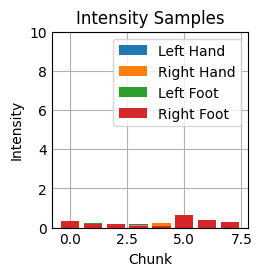

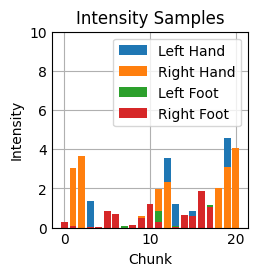

In [22]:
def simpleIntensity(obj, lastPositions):
  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])
  if (distance == 0):
    return 0
  if (time == 0):
    return math.inf
  return distance / time

plotSampledGetMinIntensity(simpleIntensity)

In [23]:
def rightLegAmputeeIntensity(obj, lastPositions):
  if (obj[3] == 9):
    return math.inf
  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])
  if (distance == 0):
    return 0
  if (time == 0):
    return math.inf
  return distance / time

# plotSampledGetMinIntensity(rightLegAmputeeIntensity)

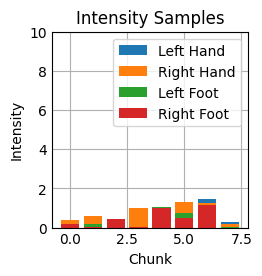

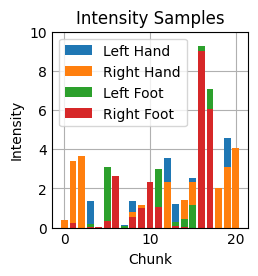

In [24]:
velocity = {
  6: 0,
  7: 0,
  8: 0,
  9: 0
}

def intensity(obj, lastPositions):
  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])

  # General edge cases
  if (distance == 0):
    return 0
  if (time == 0):
    return math.inf

  # Hands
  if (obj[3] == 6 or obj[3] == 7):
    return distance / time
  # Feet
  elif (obj[3] == 8 or obj[3] == 9):
    return distance / time * (2 + obj[1]) ** 4
  return math.inf

plotSampledGetMinIntensity(intensity)